In [12]:
!pip install chess
from IPython.core.display import display, HTML # for some notebook formatting.

import mlrose_hiive
import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import string


from ast import literal_eval
import chess

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator, FourPeaks, FlipFlopGenerator, KnapsackGenerator
from mlrose_hiive import SARunner, GARunner, NNGSRunner
from mlrose_hiive import DiscreteOpt
from mlrose_hiive import SARunner, GARunner, NNGSRunner, RHCRunner
from A2_helpers.Four_peaks_helpers import Runner_overSeeds

import subprocess
import random
from pathlib import Path
import os
import sys
# Get the parent directory of the current notebook
current_dir = Path().resolve()
from pathlib import Path
sys.path.append(os.path.join(current_dir, 'pyperch'))
from sklearn.model_selection import validation_curve


import numpy as np
from sklearn.datasets import make_classification
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch import NeuralNet

from skorch.dataset import unpack_data
import copy
import matplotlib.pyplot as plt


import pandas as pd


# Installation on Google Colab
!git clone https://github.com/jlm429/pyperch
import pyperch
from pyperch.neural.rhc_nn import RHCModule  
from pyperch.neural.sa_nn import SAModule  
from pyperch.neural.ga_nn import GAModule  
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass



# switch off the chatter
logging.basicConfig(level=logging.WARNING)

# fitness funcions list
#https://mlrose.readthedocs.io/en/stable/source/fitness.html#fitness

# about the mlrose setup
#https://mlrose.readthedocs.io/en/stable/source/tutorial1.html

# algos
# https://mlrose.readthedocs.io/en/stable/source/algorithms.html#algs

# pyperch source
# https://github.com/jlm429/pyperch/blob/master/notebooks/rhc_opt_network.ipynb

def generate_seeds():
    torch.manual_seed(42)
    # torch.use_deterministic_algorithms(True)
    np.random.seed(42)
    random.seed(42)
    
import os
os.environ['PYTHONHASHSEED'] = '42'
generate_seeds()

fatal: destination path 'pyperch' already exists and is not an empty directory.


In [2]:
# !pip install torch
# !pip install skorch
# !pip install ucimlrepo

# # uncomment if you need to install packages
#hp temp, crossover, mutation rates

In [13]:
def increase_font_size(plt, label_fontsize=14*1.25, title_fontsize=16*1.25, legend_fontsize=12*1.1, tick_fontsize=12*1.25):
    """
    Increases the font size for labels, title, legend, and tick labels of the current plot.
    
    Parameters:
    plt (module): The Matplotlib pyplot module.
    label_fontsize (int): Font size for the x and y labels.
    title_fontsize (int): Font size for the title.
    legend_fontsize (int): Font size for the legend.
    tick_fontsize (int): Font size for the tick labels.
    """
    ax = plt.gca()
    ax.set_xlabel(ax.get_xlabel(), fontsize=label_fontsize)
    ax.set_ylabel(ax.get_ylabel(), fontsize=label_fontsize)
    ax.set_title(ax.get_title(), fontsize=title_fontsize)
    ax.legend(prop={'size': legend_fontsize})
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

In [14]:
from skorch.callbacks import EpochScoring 
import random
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
generate_seeds()
# net = NeuralNetClassifier(
#     module=RHCModule,
#     module__input_dim=7,
#     module__output_dim=2,
#     module__hidden_units=20,
#     module__hidden_layers=1,
#     module__step_size=.05,
#     max_epochs=300,
#     verbose=0,
#     # set the optimizer
#     # optimizer=torch.optim.Adam,
#     callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
#     # Shuffle training data on each epoch
#     iterator_train__shuffle=True,
# )


class NeuralNetClassifierWithSeed(NeuralNetClassifier):
  def fit(self, X, y=None, **fit_params):
        
          np.random.seed(42)
          #random.seed(42)
          torch.manual_seed(42)
          
          # if torch.cuda.is_available():
          #     torch.cuda.manual_seed(42)
          return super().fit(X, y, **fit_params)

def NN_pipeline(X_columns,module=RHCModule,**kwargs):
  """
  NN_pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', NeuralNetClassifier(BackpropModule, **kwargs))
  ])
  MLPClassifier.__class__.__name__ = f'NN'
   https://github.com/jlm429/pyperch/blob/master/notebooks/backprop_network.ipynb
  """

  # Define a function that converts data to numpy arrays
  def to_numpy(X):
      return np.array(X)
  generate_seeds()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
  print(device)
  dict_of_params = {
    "module__input_dim": 7,
    "module__output_dim": 2,
    "module__hidden_layers": 1,
    "max_epochs": 800,
    "verbose": 0,
    "lr": 0.05,
     "batch_size": 128,
    "module__hidden_units": 25,
    "module__hidden_layers": 1,
    "module__activation": torch.nn.ReLU(),
    "module__input_dim": 7,
    # "optimizer__lr": 0.002500,
    # "max_epochs": 88,
    "iterator_train__shuffle": False
}
  dict_of_params.update(kwargs)

  # Define the F1 score callback for training and validation
  train_f1 = EpochScoring(scoring='accuracy', lower_is_better=False, on_train=True, name='train_f1')
  valid_f1 = EpochScoring(scoring='accuracy', lower_is_better=False, on_train=False, name='valid_f1')
  
  # train and valid log loss
  train_log_loss = EpochScoring(scoring='neg_log_loss', lower_is_better=True, on_train=True, name='train_log_loss')
  valid_log_loss = EpochScoring(scoring='neg_log_loss', lower_is_better=True, on_train=False, name='valid_log_loss')
  
  
  

  net = NeuralNetClassifier(
    module=module,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True)],
    #  train_split=predefined_split(dataset_valid),
    criterion=nn.CrossEntropyLoss(),
    # optimizer = torch.optim.Adam,
    device = device,
    **dict_of_params
  )

  preprocessor = ColumnTransformer(
      transformers=[
          ('num', StandardScaler(), X_columns)
      ],
      remainder='passthrough'
  )

  # HACK Ensure the module's weights are converted to float32
  net.initialize()
  net.module_.float()

  net_pipeline = Pipeline(steps=[
          ('preprocessor', preprocessor),
          #  ('to_numpy', NumpyTransformer()),
            #  ("dummy", FunctionTransformer(func=lambda x: print(x))),
          ('classifier', net)
    ])

  net_pipeline.__class__.__name__ = f'NN'
  return net_pipeline



In [15]:
from ucimlrepo import fetch_ucirepo

predict_raison= fetch_ucirepo(id=850)

# data (as pandas dataframes)
X = predict_raison.data.features
y = predict_raison.data.targets

# metadata
print(predict_raison.metadata)

# variable information
print(predict_raison.variables)

{'uci_id': 850, 'name': 'Raisin', 'repository_url': 'https://archive.ics.uci.edu/dataset/850/raisin', 'data_url': 'https://archive.ics.uci.edu/static/public/850/data.csv', 'abstract': 'Images of the Kecimen and Besni raisin varieties were obtained with CVS. A total of 900 raisins were used, including 450 from both varieties, and 7 morphological features were extracted.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 900, 'num_features': 7, 'feature_types': ['Real', 'Integer'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5660T', 'creators': ['İ̇lkay Çinar', 'Murat Koklu', 'Sakir Tasdemir'], 'intro_paper': {'title': 'Kuru Üzüm Tanelerinin Makine Görüşü ve Yapay Zeka Yöntemleri Kullanılarak Sınıflandırılması', 'authors': 'İ̇lkay Çinar, Murat Koklu, Sakir Tasdemir

In [16]:
# divide data into train/test splits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import  GridSearchCV
from sklearn.model_selection import KFold
generate_seeds()
cv = KFold(n_splits=4, shuffle=False)

# generate_seed()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.values.ravel())
y_test_encoded = label_encoder.transform(y_test.values.ravel())

y_train_encoded

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,

In [17]:

best_epoch_from_a1 = 88
best_train_loss_from_a1 = 0.88
best_val_loss_from_a1 = 0.89

In [8]:
y.value_counts()

Class  
Besni      450
Kecimen    450
Name: count, dtype: int64

# RHC Optimization

In [9]:

generate_seeds()
RHCModule.register_rhc_training_step()

kwargs_rhc = {

    "classifier__module__step_size": [0.1, 0.2, 0.4,0.8],
    "classifier__max_epochs": [88],
}
net_rhc = NN_pipeline(X_train.columns,module=RHCModule)

cpu


In [30]:
generate_seeds()
gs_rhc = GridSearchCV(net_rhc, kwargs_rhc, refit='accuracy',cv=cv,scoring=('accuracy'), return_train_score=True,n_jobs=1)
gs_rhc.fit(X_train.astype(np.float32), y_train_encoded.astype(np.int64))

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             estimator=NN(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   StandardScaler(),
                                                                   Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter'],
      dtype='object'))])),
                                 ('classifier',
                                  <class 'skorch.classifier.NeuralNet...
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=7, out_features=25, bias=True)
      (1): Linear(in_features=25, out_features=25, bias=True)
      (2): Linear(in_features=25, out_features=2, bias=True)
    )
  ),
))]),
             n_jobs=1,
             param_grid={'classifier__max_epochs': [88],
                         'classifier__module__step_size': [0.1, 0.2, 0.4, 0.8]},
             refit='accuracy', return_train_score=True, scoring='accuracy')

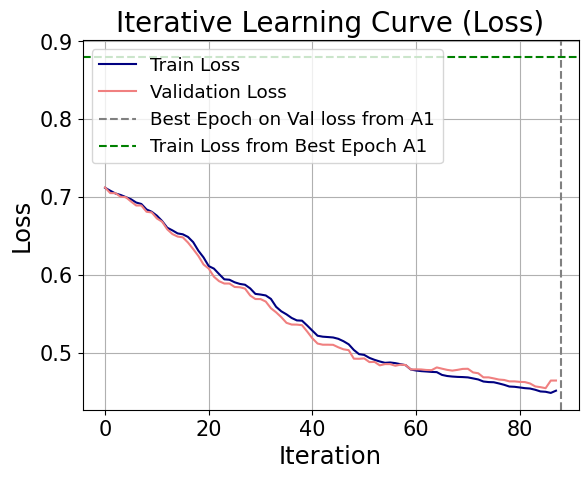

In [32]:
generate_seeds()
# plot the iterative learning curve (loss)
# Access the history from the NeuralNetClassifier object within the pipeline
best_net_rhc = gs_rhc.best_estimator_.named_steps['classifier']

history = best_net_rhc.history

# Plot the iterative learning curve (accuracy)
plt.plot(history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.axvline(x=best_epoch_from_a1, color='gray', linestyle='--', label='Best Epoch on Val loss from A1')
plt.axhline(y=best_train_loss_from_a1, color='green', linestyle='--', label='Train Loss from Best Epoch A1')
plt.title("Iterative Learning Curve (Loss)")
plt.grid(True)
plt.legend(frameon=False)
increase_font_size(plt)
plt.show()


In [ ]:
# Plot the iterative learning curve (accuracy)

plt.plot(history[:, 'train_acc'], label='Train Acc', color='navy')
plt.plot(history[:, 'valid_acc'], label='Validation Acc', color='lightcoral')
plt.axvline(x=best_epoch_from_a1, color='gray', linestyle='--', label='Best Epoch: {} on Best A1 Val ACC'.format(best_epoch_from_a1, best_val_loss_from_a1))
plt.axhline(y=best_train_loss_from_a1, color='green', linestyle='--', label='Train Acc from Best Epoch A1')
plt.xlabel("Iteration")
plt.ylabel("Acc")

# get lowest validation loss
max_val_acc_rhc = np.max(history[:, 'valid_acc'])
epoch_with_highest_val_acc = np.argmax(history[:, 'valid_acc'])
plt.axvline(x=epoch_with_highest_val_acc, color='red', linestyle='--', label='Epoch: {} with Best Validation Loss: {:.3f}'.format(epoch_with_highest_val_acc, max_val_acc_rhc),zorder=-1)

# plot x axis at 88 to compare with the previous plot
# print lowest train loss
lowest_train_loss = np.max(history[:, 'train_acc'])
epoch_with_highest_train_acc = np.max(history[:, 'train_acc'])
print( " highest_train_acc: ", lowest_train_loss, " epoch_with_highest_train_acc: ", epoch_with_highest_train_acc)
plt.title("SA (NN): Iterative Learning Curve (Acc)")
plt.grid(True)
plt.legend(frameon=False)
increase_font_size(plt)

plt.show()

In [12]:
gs_rhc.best_params_

{'classifier__max_epochs': 88, 'classifier__module__step_size': 0.4}

In [17]:
generate_seeds()
netgs_rhc = NN_pipeline(X_train.columns,module=RHCModule)
train_best_params_sa = { k:[v]for k,v in gs_rhc.best_params_.items()}
train_best_params_sa["classifier__max_epochs"] = [500]
netgs_rhc_best = GridSearchCV(netgs_rhc,train_best_params_sa, refit='accuracy',cv=cv,scoring=('accuracy'), return_train_score=True,n_jobs=1)


netgs_rhc_best.fit(X_train.astype(np.float32), y_train_encoded.astype(np.int64))

cpu


GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             estimator=NN(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   StandardScaler(),
                                                                   Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter'],
      dtype='object'))])),
                                 ('classifier',
                                  <class 'skorch.classifier.NeuralNet...
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=7, out_features=25, bias=True)
      (1): Linear(in_features=25, out_features=25, bias=True)
      (2): Linear(in_features=25, out_features=2, bias=True)
    )
  ),
))]),
             n_jobs=1,
             param_grid={'classifier__max_epochs': [500],
                         'classifier__module__step_size': [0.4]},
             refit='accuracy', return_train_score=True, scoring='accuracy')

 lowest_train_loss:  0.42666148477130467  epoch_with_lowest_train_loss:  368


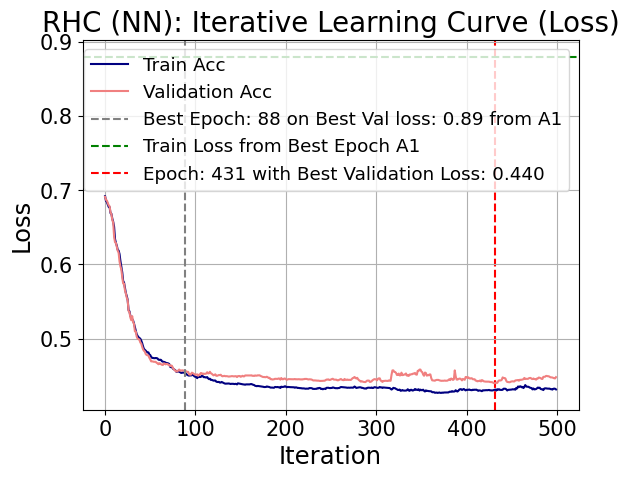

In [51]:
generate_seeds()
best_net_rhc = netgs_rhc_best.best_estimator_.named_steps['classifier']

history = best_net_rhc.history

# Plot the iterative learning curve (accuracy)

plt.plot(history[:, 'train_loss'], label='Train Acc', color='navy')
plt.plot(history[:, 'valid_loss'], label='Validation Acc', color='lightcoral')
plt.axvline(x=best_epoch_from_a1, color='gray', linestyle='--', label='Best Epoch: {} on Best Val loss: {} from A1'.format(best_epoch_from_a1, best_val_loss_from_a1))
plt.axhline(y=best_train_loss_from_a1, color='green', linestyle='--', label='Train Loss from Best Epoch A1')
plt.xlabel("Iteration")
plt.ylabel("Loss")

# get lowest validation loss
lowest_val_loss_rhc = np.min(history[:, 'valid_loss'])
epoch_with_lowest_val_loss = np.argmin(history[:, 'valid_loss'])
plt.axvline(x=epoch_with_lowest_val_loss, color='red', linestyle='--', label='Epoch: {} with Best Validation Loss: {:.3f}'.format(epoch_with_lowest_val_loss, lowest_val_loss_rhc),zorder=-1)

# plot x axis at 88 to compare with the previous plot
# print lowest train loss
lowest_train_loss = np.min(history[:, 'train_loss'])
epoch_with_lowest_train_loss = np.argmin(history[:, 'train_loss'])
print( " lowest_train_loss: ", lowest_train_loss, " epoch_with_lowest_train_loss: ", epoch_with_lowest_train_loss)
plt.title("RHC (NN): Iterative Learning Curve (Loss)")
plt.grid(True)
plt.legend(frameon=False)
increase_font_size(plt)

plt.show()

 highest_train_acc:  0.890625  epoch_with_highest_train_acc:  374


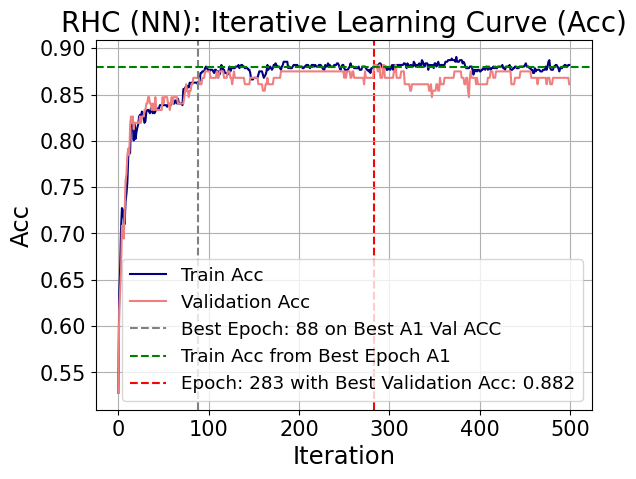

In [52]:

plt.plot(history[:, 'train_acc'], label='Train Acc', color='navy')
plt.plot(history[:, 'valid_acc'], label='Validation Acc', color='lightcoral')
plt.axvline(x=best_epoch_from_a1, color='gray', linestyle='--', label='Best Epoch: {} on Best A1 Val ACC'.format(best_epoch_from_a1, best_val_loss_from_a1))
plt.axhline(y=best_train_loss_from_a1, color='green', linestyle='--', label='Train Acc from Best Epoch A1')
plt.xlabel("Iteration")
plt.ylabel("Acc")

# get lowest validation loss
max_val_acc_rhc = np.max(history[:, 'valid_acc'])
epoch_with_highest_val_acc = np.argmax(history[:, 'valid_acc'])
plt.axvline(x=epoch_with_highest_val_acc, color='red', linestyle='--', label='Epoch: {} with Best Validation Acc: {:.3f}'.format(epoch_with_highest_val_acc, max_val_acc_rhc),zorder=-1)

# plot x axis at 88 to compare with the previous plot
# print lowest train loss
highest_train_acc = np.max(history[:, 'train_acc'])
epoch_with_highest_train_acc = np.argmax(history[:, 'train_acc'])
print( " highest_train_acc: ", highest_train_acc, " epoch_with_highest_train_acc: ", epoch_with_highest_train_acc)
plt.title("RHC (NN): Iterative Learning Curve (Acc)")
plt.grid(True)
plt.legend(frameon=False)
increase_font_size(plt)

plt.show()

In [41]:
# create a validation curve for the step size parameter
generate_seeds()
# Create the validation curve
best_params = gs_rhc.best_params_.copy()
step_size_param = 'classifier__module__step_size'
del best_params[step_size_param]

# Filter the results to match the best parameters except for 'classifier__module__t'
results = gs_rhc.cv_results_

# Get the unique t values from the grid search
t_values = kwargs_rhc[step_size_param]

train_scores = []
valid_scores = []

for t_value in t_values:
    # Create a mask for the best parameters with the current t_value
    mask = np.ones(len(results['mean_train_score']), dtype=bool)
    for param, value in best_params.items():
        mask = mask & (results[f'param_{param}'] == value)
    mask = mask & (results[f'param_{step_size_param}'] == t_value)
    
    # Extract the relevant train and test scores
    train_score = results['mean_train_score'][mask]
    valid_score = results['mean_test_score'][mask]
    
    train_scores.append(train_score)
    valid_scores.append(valid_score)

# Calculate the mean and standard deviation for the training and validation set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Create a table of the results
results_df = pd.DataFrame({
    'T Value': t_values,
    'Train Mean': train_mean,
    'Train Std': train_std,
    'Valid Mean': valid_mean,
    'Valid Std': valid_std
})

# Display the results
print(results_df)


   T Value  Train Mean  Train Std  Valid Mean  Valid Std
0      0.1    0.814815        0.0    0.809722        0.0
1      0.2    0.850000        0.0    0.848611        0.0
2      0.4    0.869444        0.0    0.872222        0.0
3      0.8    0.869444        0.0    0.872222        0.0


# SA NN Optimization

In [42]:
 
generate_seeds()
SAModule.register_sa_training_step()

kwargs_sa = {
     "classifier__module__t":[2000,20000/2, 20000, 20000*2],
    "classifier__module__cooling":[0.2,0.50, 0.8,0.9], # in practice decreease temp slowly https://edstem.org/us/courses/58650/lessons/104083/slides/587009
    "classifier__module__step_size": [0.1, 0.2, 0.4,0.8],
    "classifier__max_epochs": [88],
}
net_sa = NN_pipeline(X_train.columns,module=SAModule)

cpu


In [43]:
generate_seeds()
gs_sa = GridSearchCV(net_sa, kwargs_sa, refit='accuracy',cv=cv,scoring=('accuracy'), return_train_score=True,n_jobs=1)
gs_sa.fit(X_train.astype(np.float32), y_train_encoded.astype(np.int64))

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             estimator=NN(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   StandardScaler(),
                                                                   Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter'],
      dtype='object'))])),
                                 ('classifier',
                                  <class 'skorch.classifier.NeuralNet...
      (1): Linear(in_features=25, out_features=25, bias=True)
      (2): Linear(in_features=25, out_features=2, bias=True)
    )
  ),
))]),
             n_jobs=1,
             param_grid={'classifier__max_epochs': [88],
                         'classifier__module__cooling': [0.2, 0.5, 0.8, 0.9],
                         'classifier__module__step_size': [0.1, 0.2, 0.4, 0.8],
                         'classifier__module__t': [2000, 10000.0, 20000,
                                                   40000]},
             refit='accuracy', return_train_score=True, scoring='accuracy')

In [44]:
# Create the validation curve
# Assuming netgs_rhc_best is the GridSearchCV object
generate_seeds()
import numpy as np
import pandas as pd

# Get the best parameters excluding 'classifier__module__step_size'
best_params = gs_sa.best_params_.copy()
step_size_param = 'classifier__module__step_size'
del best_params[step_size_param]

# Filter the results to match the best parameters except for 'classifier__module__step_size'
results = gs_sa.cv_results_

# Get the unique step size values from the grid search
step_sizes = kwargs_rhc[step_size_param]

train_scores = []
valid_scores = []

for step_size in step_sizes:
    # Create a mask for the best parameters with the current step_size
    mask = np.ones(len(results['mean_train_score']), dtype=bool)
    for param, value in best_params.items():
        mask = mask & (results[f'param_{param}'] == value)
    mask = mask & (results[f'param_{step_size_param}'] == step_size)
    
    # Extract the relevant train and test scores
    train_score = results['mean_train_score'][mask]
    valid_score = results['mean_test_score'][mask]
    
    train_scores.append(train_score)
    valid_scores.append(valid_score)

# Calculate the mean and standard deviation for the training and validation set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Create a table of the results
results_df = pd.DataFrame({
    'Step Size': step_sizes,
    'Train Mean': train_mean,
    'Train Std': train_std,
    'Valid Mean': valid_mean,
    'Valid Std': valid_std
})

# Display the results
print(results_df)


   Step Size  Train Mean  Train Std  Valid Mean  Valid Std
0        0.1    0.704167        0.0    0.725000        0.0
1        0.2    0.831019        0.0    0.826389        0.0
2        0.4    0.834722        0.0    0.843056        0.0
3        0.8    0.873148        0.0    0.876389        0.0


In [19]:
# import pickle
# try:
#     if gs_sa:
#         # pickle gs
#         with open('gs_sa.pkl', 'wb') as f:
#             pickle.dump(gs_sa, f)
# except:
#     with open('gs_sa.pkl', 'rb') as f:
#         gs_sa = pickle.load(f)

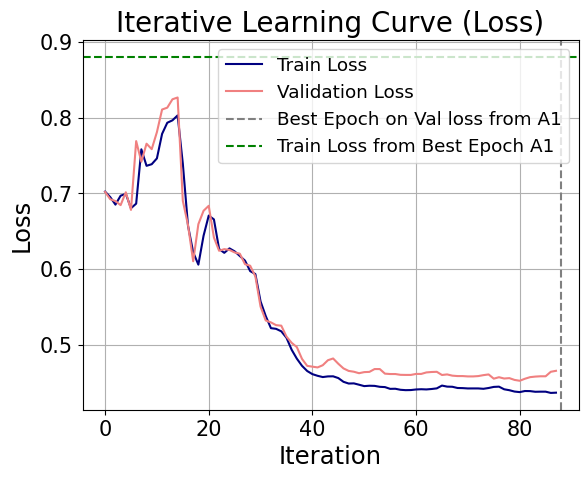

In [45]:
best_net_sa = gs_sa.best_estimator_.named_steps['classifier']

history = best_net_sa.history

# Plot the iterative learning curve (accuracy)

plt.plot(history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.axvline(x=best_epoch_from_a1, color='gray', linestyle='--', label='Best Epoch on Val loss from A1')
plt.axhline(y=best_train_loss_from_a1, color='green', linestyle='--', label='Train Loss from Best Epoch A1')
plt.xlabel("Iteration")
plt.ylabel("Loss")
# plot x axis at 88 to compare with the previous plot

plt.title("Iterative Learning Curve (Loss)")
plt.grid(True)
plt.legend(frameon=False)
increase_font_size(plt)

plt.show()

In [46]:
# list best hyperparameters 
gs_sa.best_params_


{'classifier__max_epochs': 88,
 'classifier__module__cooling': 0.9,
 'classifier__module__step_size': 0.8,
 'classifier__module__t': 2000}

In [47]:
## retrain the model with best hyperparameters until convergence 
generate_seeds()
netgs_sa = NN_pipeline(X_train.columns,module=SAModule)
train_best_params_sa = { k:[v]for k,v in gs_sa.best_params_.items()}
train_best_params_sa["classifier__max_epochs"] = [500]
netgs_sa_best = GridSearchCV(netgs_sa,train_best_params_sa, refit='accuracy',cv=cv,scoring=('accuracy'), return_train_score=True,n_jobs=1)


netgs_sa_best.fit(X_train.astype(np.float32), y_train_encoded.astype(np.int64))




cpu


GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             estimator=NN(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   StandardScaler(),
                                                                   Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter'],
      dtype='object'))])),
                                 ('classifier',
                                  <class 'skorch.classifier.NeuralNet...
      (0): Linear(in_features=7, out_features=25, bias=True)
      (1): Linear(in_features=25, out_features=25, bias=True)
      (2): Linear(in_features=25, out_features=2, bias=True)
    )
  ),
))]),
             n_jobs=1,
             param_grid={'classifier__max_epochs': [500],
                         'classifier__module__cooling': [0.9],
                         'classifier__module__step_size': [0.8],
                         'classifier__module__t': [2000]},
             refit='accuracy', return_train_score=True, scoring='accuracy')

 lowest_train_loss:  0.4211370183361901  epoch_with_lowest_train_loss:  407


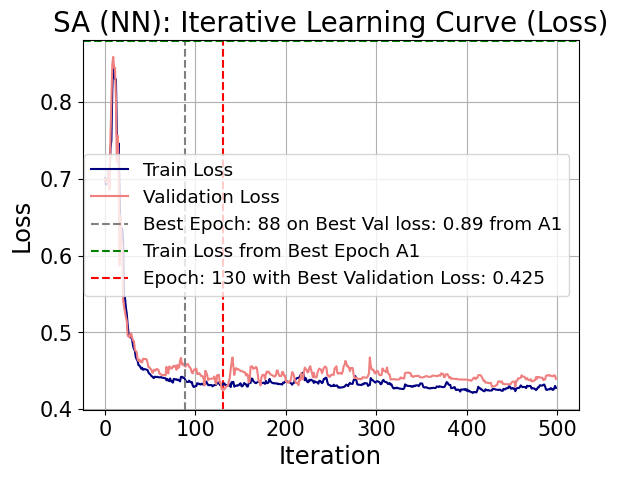

In [55]:
best_net_sa = netgs_sa_best.best_estimator_.named_steps['classifier']

history = best_net_sa.history

# Plot the iterative learning curve (accuracy)

plt.plot(history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.axvline(x=best_epoch_from_a1, color='gray', linestyle='--', label='Best Epoch: {} on Best Val loss: {} from A1'.format(best_epoch_from_a1, best_val_loss_from_a1))
plt.axhline(y=best_train_loss_from_a1, color='green', linestyle='--', label='Train Loss from Best Epoch A1')
plt.xlabel("Iteration")
plt.ylabel("Loss")

# get lowest validation loss
lowest_val_loss_sa = np.min(history[:, 'valid_loss'])
epoch_with_lowest_val_loss = np.argmin(history[:, 'valid_loss'])
plt.axvline(x=epoch_with_lowest_val_loss, color='red', linestyle='--', label='Epoch: {} with Best Validation Loss: {:.3f}'.format(epoch_with_lowest_val_loss, lowest_val_loss_sa),zorder=-1)
# print lowest train loss
lowest_train_loss = np.min(history[:, 'train_loss'])
epoch_with_lowest_train_loss = np.argmin(history[:, 'train_loss'])
print( " lowest_train_loss: ", lowest_train_loss, " epoch_with_lowest_train_loss: ", epoch_with_lowest_train_loss)
# plot x axis at 88 to compare with the previous plot

plt.title("SA (NN): Iterative Learning Curve (Loss)")
plt.grid(True)
plt.legend(frameon=False)
increase_font_size(plt)

plt.show()

 highest_train_acc:  0.8940972222222222  epoch_with_highest_train_acc:  410


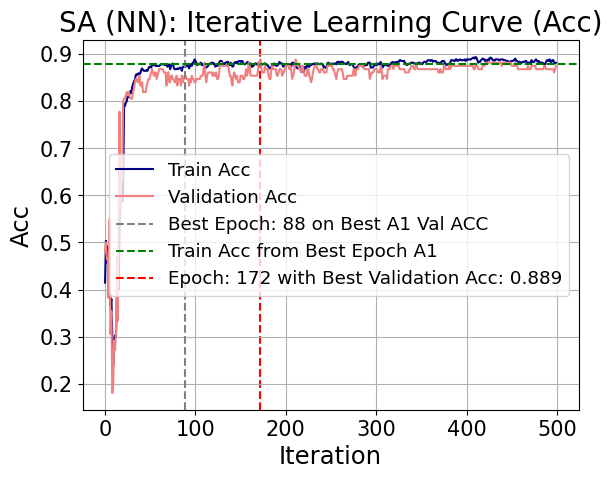

In [56]:

plt.plot(history[:, 'train_acc'], label='Train Acc', color='navy')
plt.plot(history[:, 'valid_acc'], label='Validation Acc', color='lightcoral')
plt.axvline(x=best_epoch_from_a1, color='gray', linestyle='--', label='Best Epoch: {} on Best A1 Val ACC'.format(best_epoch_from_a1, best_val_loss_from_a1))
plt.axhline(y=best_train_loss_from_a1, color='green', linestyle='--', label='Train Acc from Best Epoch A1')
plt.xlabel("Iteration")
plt.ylabel("Acc")

# get lowest validation loss
max_val_acc_rhc = np.max(history[:, 'valid_acc'])
epoch_with_highest_val_acc = np.argmax(history[:, 'valid_acc'])
plt.axvline(x=epoch_with_highest_val_acc, color='red', linestyle='--', label='Epoch: {} with Best Validation Acc: {:.3f}'.format(epoch_with_highest_val_acc, max_val_acc_rhc),zorder=-1)

# plot x axis at 88 to compare with the previous plot
# print lowest train loss
highest_train_acc = np.max(history[:, 'train_acc'])
epoch_with_highest_train_acc = np.argmax(history[:, 'train_acc'])
print( " highest_train_acc: ", highest_train_acc, " epoch_with_highest_train_acc: ", epoch_with_highest_train_acc)
plt.title("SA (NN): Iterative Learning Curve (Acc)")
plt.grid(True)
plt.legend(frameon=False)
increase_font_size(plt)

plt.show()

In [57]:
generate_seeds()
# Create the validation curve
best_params = gs_sa.best_params_.copy()
t_param = 'classifier__module__t'
del best_params[t_param]

# Filter the results to match the best parameters except for 'classifier__module__t'
results = gs_sa.cv_results_

# Get the unique t values from the grid search
t_values = kwargs_sa[t_param]

train_scores = []
valid_scores = []

for t_value in t_values:
    # Create a mask for the best parameters with the current t_value
    mask = np.ones(len(results['mean_train_score']), dtype=bool)
    for param, value in best_params.items():
        mask = mask & (results[f'param_{param}'] == value)
    mask = mask & (results[f'param_{t_param}'] == t_value)
    
    # Extract the relevant train and test scores
    train_score = results['mean_train_score'][mask]
    valid_score = results['mean_test_score'][mask]
    
    train_scores.append(train_score)
    valid_scores.append(valid_score)

# Calculate the mean and standard deviation for the training and validation set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Create a table of the results
results_df = pd.DataFrame({
    'T Value': t_values,
    'Train Mean': train_mean,
    'Train Std': train_std,
    'Valid Mean': valid_mean,
    'Valid Std': valid_std
})

# Display the results
print(results_df)

   T Value  Train Mean  Train Std  Valid Mean  Valid Std
0   2000.0    0.873148        0.0    0.876389        0.0
1  10000.0    0.864352        0.0    0.862500        0.0
2  20000.0    0.867130        0.0    0.855556        0.0
3  40000.0    0.866667        0.0    0.872222        0.0


## GA NN Optimization



In [90]:
generate_seeds()
GAModule.register_ga_training_step()

kwargs_ga = {
    "classifier__module__to_mutate": [15, 30, 45, 60],
    "classifier__module__population_size": [257,300,400],  # Use integer values
    "classifier__module__to_mate": [32, 64, 128, 256],
    "classifier__max_epochs": [88],
}
net_ga = NN_pipeline(X_train.columns, module=GAModule)

cpu


In [91]:
gs_ga = GridSearchCV(net_ga, kwargs_ga, refit='accuracy', cv=cv, scoring='accuracy', return_train_score=True, n_jobs=1)
gs_ga.fit(X_train.astype(np.float32), torch.tensor(y_train_encoded.astype(np.int64), dtype=torch.long))

In [ ]:
import pickle
if'gs_ga' in locals():
    # pickle gs
    with open('gs_ga.pkl', 'wb') as f:
        pickle.dump(gs_ga, f)
else:
    with open('gs_ga.pkl', 'rb') as f:
        gs_ga = pickle.load(f)
with open('gs_ga.pkl', 'rb') as f:
    gs_ga = pickle.load(f)       


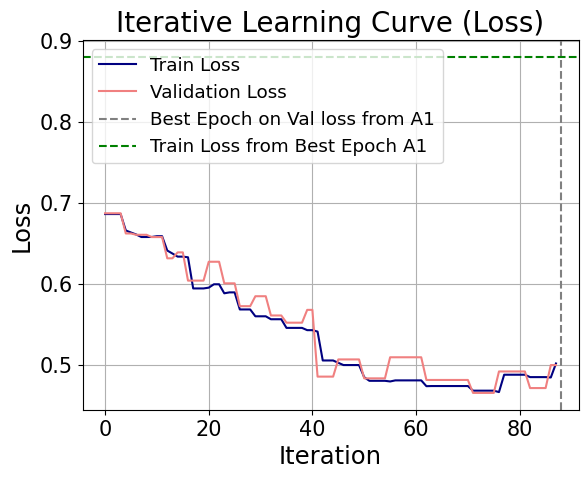

In [73]:
best_net_ga = gs_ga.best_estimator_.named_steps['classifier']

history = best_net_ga.history

# Plot the iterative learning curve (accuracy)

plt.plot(history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.axvline(x=best_epoch_from_a1, color='gray', linestyle='--', label='Best Epoch on Val loss from A1')
plt.axhline(y=best_train_loss_from_a1, color='green', linestyle='--', label='Train Loss from Best Epoch A1')
plt.xlabel("Iteration")
plt.ylabel("Loss")
# plot x axis at 88 to compare with the previous plot

plt.title("Iterative Learning Curve (Loss)")
plt.grid(True)
plt.legend(frameon=False)
increase_font_size(plt)

plt.show()

In [ ]:
gs_ga.best_params_

{'classifier__max_epochs': 88,
 'classifier__module__population_size': 257,
 'classifier__module__to_mate': 64,
 'classifier__module__to_mutate': 30}

In [79]:
## retrain the model with best hyperparameters until convergence 
generate_seeds()
netgs_ga = NN_pipeline(X_train.columns,module=GAModule)
train_best_params_ga = { k:[v]for k,v in gs_ga.best_params_.items()}
train_best_params_ga["classifier__max_epochs"] = [400]
netgs_ga_best = GridSearchCV(netgs_ga,train_best_params_ga, refit='accuracy',cv=cv,scoring=('accuracy'), return_train_score=True,n_jobs=1)


netgs_ga_best.fit(X_train.astype(np.float32), y_train_encoded.astype(np.int64))


cpu


GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             estimator=NN(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   StandardScaler(),
                                                                   Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter'],
      dtype='object'))])),
                                 ('classifier',
                                  <class 'skorch.classifier.NeuralNet...
      (0): Linear(in_features=7, out_features=25, bias=True)
      (1): Linear(in_features=25, out_features=25, bias=True)
      (2): Linear(in_features=25, out_features=2, bias=True)
    )
  ),
))]),
             n_jobs=1,
             param_grid={'classifier__max_epochs': [400],
                         'classifier__module__population_size': [257],
                         'classifier__module__to_mate': [64],
                         'classifier__module__to_mutate': [30]},
             refit='accuracy', return_train_score=True, scoring='accuracy')

 lowest_train_loss:  0.4260721173551347  epoch_with_lowest_train_loss:  181


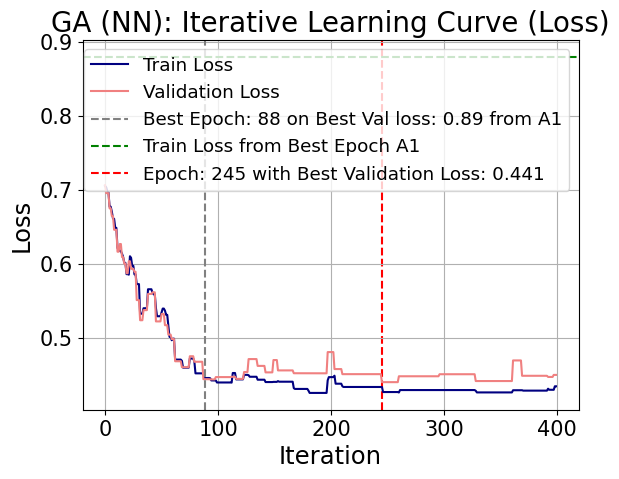

In [80]:
best_net_ga = netgs_ga_best.best_estimator_.named_steps['classifier']

history = best_net_ga.history

# Plot the iterative learning curve (accuracy)

plt.plot(history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.axvline(x=best_epoch_from_a1, color='gray', linestyle='--', label='Best Epoch: {} on Best Val loss: {} from A1'.format(best_epoch_from_a1, best_val_loss_from_a1))
plt.axhline(y=best_train_loss_from_a1, color='green', linestyle='--', label='Train Loss from Best Epoch A1')
plt.xlabel("Iteration")
plt.ylabel("Loss")

# get lowest validation loss
lowest_val_loss_ga = np.min(history[:, 'valid_loss'])
epoch_with_lowest_val_loss = np.argmin(history[:, 'valid_loss'])
plt.axvline(x=epoch_with_lowest_val_loss, color='red', linestyle='--', label='Epoch: {} with Best Validation Loss: {:.3f}'.format(epoch_with_lowest_val_loss, lowest_val_loss_ga),zorder=-1)

# plot x axis at 88 to compare with the previous plot
# print lowest train loss
lowest_train_loss = np.min(history[:, 'train_loss'])
epoch_with_lowest_train_loss = np.argmin(history[:, 'train_loss'])
print( " lowest_train_loss: ", lowest_train_loss, " epoch_with_lowest_train_loss: ", epoch_with_lowest_train_loss)


plt.title("GA (NN): Iterative Learning Curve (Loss)")
plt.grid(True)
plt.legend(frameon=False)
increase_font_size(plt)

plt.show()

 highest_train_acc:  0.8888888888888888  epoch_with_highest_train_acc:  181


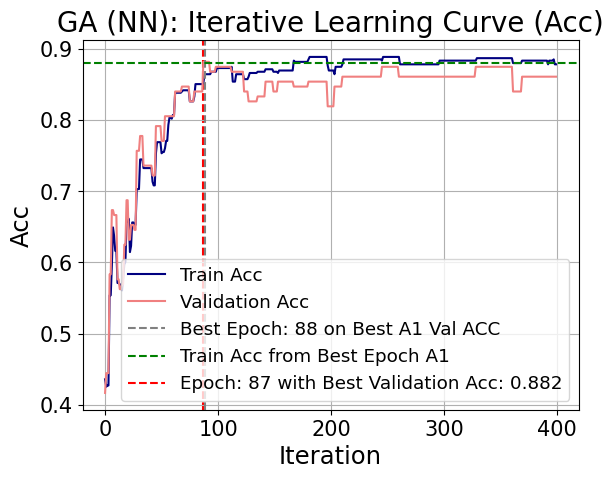

In [83]:

plt.plot(history[:, 'train_acc'], label='Train Acc', color='navy')
plt.plot(history[:, 'valid_acc'], label='Validation Acc', color='lightcoral')
plt.axvline(x=best_epoch_from_a1, color='gray', linestyle='--', label='Best Epoch: {} on Best A1 Val ACC'.format(best_epoch_from_a1, best_val_loss_from_a1))
plt.axhline(y=best_train_loss_from_a1, color='green', linestyle='--', label='Train Acc from Best Epoch A1')
plt.xlabel("Iteration")
plt.ylabel("Acc")

# get lowest validation loss
max_val_acc_rhc = np.max(history[:, 'valid_acc'])
epoch_with_highest_val_acc = np.argmax(history[:, 'valid_acc'])
plt.axvline(x=epoch_with_highest_val_acc, color='red', linestyle='--', label='Epoch: {} with Best Validation Acc: {:.3f}'.format(epoch_with_highest_val_acc, max_val_acc_rhc),zorder=-1)

# plot x axis at 88 to compare with the previous plot
# print lowest train loss
highest_train_acc = np.max(history[:, 'train_acc'])
epoch_with_highest_train_acc = np.argmax(history[:, 'train_acc'])
print( " highest_train_acc: ", highest_train_acc, " epoch_with_highest_train_acc: ", epoch_with_highest_train_acc)
plt.title("GA (NN): Iterative Learning Curve (Acc)")
plt.grid(True)
plt.legend(frameon=False)
increase_font_size(plt)

plt.show()

 highest_train_acc:  181  epoch_with_highest_train_acc:  181


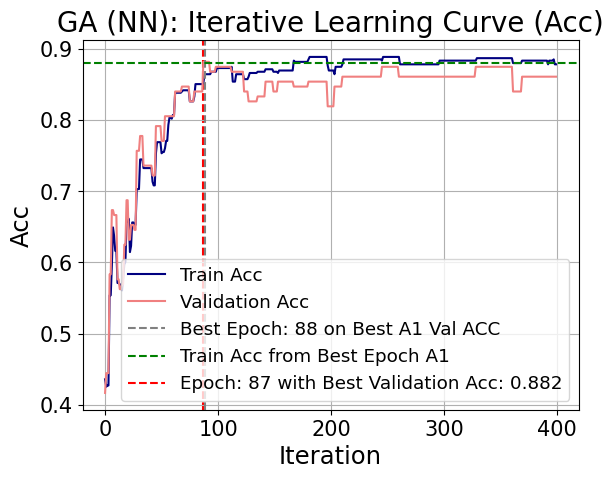

In [84]:

plt.plot(history[:, 'train_acc'], label='Train Acc', color='navy')
plt.plot(history[:, 'valid_acc'], label='Validation Acc', color='lightcoral')
plt.axvline(x=best_epoch_from_a1, color='gray', linestyle='--', label='Best Epoch: {} on Best A1 Val ACC'.format(best_epoch_from_a1, best_val_loss_from_a1))
plt.axhline(y=best_train_loss_from_a1, color='green', linestyle='--', label='Train Acc from Best Epoch A1')
plt.xlabel("Iteration")
plt.ylabel("Acc")

# get lowest validation loss
max_val_acc_rhc = np.max(history[:, 'valid_acc'])
epoch_with_highest_val_acc = np.argmax(history[:, 'valid_acc'])
plt.axvline(x=epoch_with_highest_val_acc, color='red', linestyle='--', label='Epoch: {} with Best Validation Acc: {:.3f}'.format(epoch_with_highest_val_acc, max_val_acc_rhc),zorder=-1)

# plot x axis at 88 to compare with the previous plot
# print lowest train loss
highest_train_acc = np.max(history[:, 'train_acc'])
epoch_with_highest_train_acc = np.argmax(history[:, 'train_acc'])
print( " highest_train_acc: ", epoch_with_highest_train_acc, " epoch_with_highest_train_acc: ", epoch_with_highest_train_acc)
plt.title("GA (NN): Iterative Learning Curve (Acc)")
plt.grid(True)
plt.legend(frameon=False)
increase_font_size(plt)

plt.show()

In [89]:
# Create the validation curve
# Assuming netgs_rhc_best is the GridSearchCV object
generate_seeds()
# get the best params
# Create the validation curve
best_params = gs_ga.best_params_.copy()
to_mate_param = 'classifier__module__to_mate'
del best_params[to_mate_param]

# Filter the results to match the best parameters except for 'classifier__module__t'
results = gs_ga.cv_results_

# Get the unique t values from the grid search
mate_values = kwargs_ga[to_mate_param]

train_scores = []
valid_scores = []

for t_value in mate_values:
    # Create a mask for the best parameters with the current t_value
    mask = np.ones(len(results['mean_train_score']), dtype=bool)
    for param, value in best_params.items():
        mask = mask & (results[f'param_{param}'] == value)
    mask = mask & (results[f'param_{to_mate_param}'] == t_value)
    
    # Extract the relevant train and test scores
    train_score = results['mean_train_score'][mask]
    valid_score = results['mean_test_score'][mask]
    
    train_scores.append(train_score)
    valid_scores.append(valid_score)

# Calculate the mean and standard deviation for the training and validation set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Create a table of the results
results_df = pd.DataFrame({
    'T Value': t_values,
    'Train Mean': train_mean,
    'Train Std': train_std,
    'Valid Mean': valid_mean,
    'Valid Std': valid_std
})

# Display the results
print(results_df)

   T Value  Train Mean  Train Std  Valid Mean  Valid Std
0   2000.0    0.835648        0.0    0.825000        0.0
1  10000.0    0.860185        0.0    0.870833        0.0
2  20000.0    0.836111        0.0    0.837500        0.0
3  40000.0    0.827778        0.0    0.826389        0.0


In [ ]:
generate_seeds()
# Create the validation curve
best_params = gs_ga.best_params_.copy()
to_mutate_param = 'classifier__module__to_mutate'
del best_params[to_mutate_param]

# Filter the results to match the best parameters except for 'classifier__module__to_mutate'
results = gs_ga.cv_results_

# Get the unique to_mutate values from the grid search
to_mutate_values = kwargs_ga[to_mutate_param]

train_scores = []
valid_scores = []

for to_mutate_value in to_mutate_values:
    # Create a mask for the best parameters with the current to_mutate_value
    mask = np.ones(len(results['mean_train_score']), dtype=bool)
    for param, value in best_params.items():
        mask = mask & (results[f'param_{param}'] == value)
    mask = mask & (results[f'param_{to_mutate_param}'] == to_mutate_value)
    
    # Extract the relevant train and test scores
    train_score = results['mean_train_score'][mask]
    valid_score = results['mean_test_score'][mask]
    
    train_scores.append(train_score)
    valid_scores.append(valid_score)

# Calculate the mean and standard deviation for the training and validation set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Create a table of the results
results_df = pd.DataFrame({
    'To Mutate Value': to_mutate_values,
    'Train Mean': train_mean,
    'Train Std': train_std,
    'Valid Mean': valid_mean,
    'Valid Std': valid_std
})

# Display the results
print(results_df)

   To Mutate Value  Train Mean  Train Std  Valid Mean  Valid Std
0               15    0.842130        0.0    0.836111        0.0
1               30    0.860185        0.0    0.870833        0.0
2               45    0.838426        0.0    0.834722        0.0
3               60    0.845833        0.0    0.844444        0.0


## Comparison of all NN learning Algos

In [18]:
from sklearn.model_selection import cross_validate
from pyperch.neural.rhc_nn import RHCModule
generate_seeds()

best_params = {
    'rhc': {'max_epochs': 283, 'module__step_size': 0.4},
    'sa': {'max_epochs': 172,
            'module__cooling': 0.9,
            'module__step_size': 0.8,
            'module__t': 2000.0
            },
    'ga': {'max_epochs': 87,
 'module__population_size': 257,
 'module__to_mate': 64,
 'module__to_mutate': 30}
    
}



GAModule.register_ga_training_step()
ga_pipeline = NN_pipeline(X_train.columns,module=GAModule, **best_params['ga'])
scores_ga = cross_validate(ga_pipeline, X_train.astype(np.float32), y_train_encoded.astype(np.int64), cv=cv, scoring='accuracy', return_train_score=True, n_jobs=2)
RHCModule.register_rhc_training_step()
rhc_pipeline = NN_pipeline(X_train.columns,module=RHCModule, **best_params['rhc'])
scores_rhc = cross_validate(rhc_pipeline, X_train.astype(np.float32), y_train_encoded.astype(np.int64), cv=cv, scoring='accuracy', return_train_score=True, n_jobs=2)
SAModule.register_sa_training_step()
sa_pipeline = NN_pipeline(X_train.columns,module=SAModule, **best_params['sa'])
scores_sa = cross_validate(sa_pipeline, X_train.astype(np.float32), y_train_encoded.astype(np.int64), cv=cv, scoring='accuracy', return_train_score=True, n_jobs=2)

# fit times
print(f"RHC fit: mean-{np.mean(scores_rhc['fit_time'])}, var-{np.var(scores_rhc['fit_time'])}")
print(f"SA fit: mean-{np.mean(scores_sa['fit_time'])}, var-{np.var(scores_sa['fit_time'])}")
print(f"GA fit: mean-{np.mean(scores_ga['fit_time'])}, var-{np.var(scores_ga['fit_time'])}")

# score times
print(f"RHC score: mean-{np.mean(scores_rhc['score_time'])}, var-{np.var(scores_rhc['score_time'])}")
print(f"SA score: mean-{np.mean(scores_sa['score_time'])}, var-{np.var(scores_sa['score_time'])}")
print(f"GA score: mean-{np.mean(scores_ga['score_time'])}, var-{np.var(scores_ga['score_time'])}")

cpu
cpu
cpu
RHC fit: mean-5.712883234024048, var-5.683257194748904
SA fit: mean-1.4896597266197205, var-0.015120558023436814
GA fit: mean-1.5420620441436768, var-0.2891624655213718
RHC score: mean-0.00956183671951294, var-4.285250615154723e-05
SA score: mean-0.004336059093475342, var-5.640422538633061e-05
GA score: mean-0.003909647464752197, var-4.585602989592985e-05


In [ ]:
generate_seeds()

RHCModule.register_rhc_training_step()
rhc_pipeline.fit(X_train.astype(np.float32), y_train_encoded.astype(np.int64) )
SAModule.register_sa_training_step()
sa_pipeline.fit(X_train.astype(np.float32), y_train_encoded.astype(np.int64) )
GAModule.register_ga_training_step()
ga_pipeline.fit(X_train.astype(np.float32), y_train_encoded.astype(np.int64) )

NN(steps=[('preprocessor',
           ColumnTransformer(remainder='passthrough',
                             transformers=[('num', StandardScaler(),
                                            Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter'],
      dtype='object'))])),
          ('classifier',
           <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=GAModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=7, out_features=25, bias=True)
      (1): Linear(in_features=25, out_features=25, bias=True)
      (2): Linear(in_features=25, out_features=2, bias=True)
    )
  ),
))])

In [ ]:
from sklearn.metrics import accuracy_score, log_loss

# Predictions
y_pred_rhc = rhc_pipeline.predict(X_test.astype(np.float32))
y_pred_sa = sa_pipeline.predict(X_test.astype(np.float32))
y_pred_ga = ga_pipeline.predict(X_test.astype(np.float32))

# Probabilities for loss calculation
y_pred_proba_rhc = rhc_pipeline.predict_proba(X_test.astype(np.float32))
y_pred_proba_sa = sa_pipeline.predict_proba(X_test.astype(np.float32))
y_pred_proba_ga = ga_pipeline.predict_proba(X_test.astype(np.float32))

# Accuracy
acc_rhc = accuracy_score(y_test_encoded, y_pred_rhc)
acc_sa = accuracy_score(y_test_encoded, y_pred_sa)
acc_ga = accuracy_score(y_test_encoded, y_pred_ga)

# Log Loss
loss_rhc = log_loss(y_test_encoded, y_pred_proba_rhc)
loss_sa = log_loss(y_test_encoded, y_pred_proba_sa)
loss_ga = log_loss(y_test_encoded, y_pred_proba_ga)

print(f"RHC Accuracy: {acc_rhc}, RHC Loss: {loss_rhc}")
print(f"SA Accuracy: {acc_sa}, SA Loss: {loss_sa}")
print(f"GA Accuracy: {acc_ga}, GA Loss: {loss_ga}")

RHC Accuracy: 0.8444444444444444, RHC Loss: 0.45697134651026783
SA Accuracy: 0.8388888888888889, SA Loss: 0.4640734452137772
GA Accuracy: 0.8555555555555555, GA Loss: 0.45548414009157107
